In [20]:
import sys
import random
import math
import sys
import time
from IPython.display import clear_output
import chess
import chess.engine
import numpy as np
import pandas as pd

#  Homework1 Chess - Author Andrea Serafini mat. 277048

Chess is a Turn Based Games where 2 player (or agents) play competively with the goal of beat the other player.
To implement this type of game different data structure and function have been implemented:

- Game and Chess Classes
- Heuristics and Chess Heuristic classes
- Alpha Beta Pruning algorithm
- play and data storage functions

### Abstract Class Game

This abstract class can be used to implement a chess game instance, it is similar to the problem class used in the puzzle problem. 

In [2]:
class Game():

    # Return a collection of the allowable moves from this state.
    def actions(self, state):    
        raise NotImplementedError
    
    # return a state State' from State and Action 
    def result(self, state, move):
        raise NotImplementedError
    # return True if a final state has been reached
    def is_terminal(self, state):
        return not self.actions(state)
    
    #return the player of the current turn
    def get_player(self, state):
        raise NotImplementedError
   
    #Returns the turn of the player current player    
    def get_turn(self, state):
        raise NotImplementedError

# Chess Class

This class will be used to instantiate a new chess game board. The board is represented by using Forsyth–Edwards Notation (FEN) that is a standard notation for describing a particular board position of a chess game. This class wrap the functions offered by the Chess library.

In [3]:
#
# Chess game with python chess library
#
class Chess(Game):
    
    def __init__(self):
        self.initial = chess.Board().fen()
        
    # Get all possible moveves of the current state    
    def actions(self, state):
        board = self.get_board(state)
        return board.legal_moves
    
    # get the resulting board after perform an action
    def result(self, state, action):
        board = self.get_board(state)
        board.push(action)
        return board.fen()
    
    # Undo Move
    def undo_move(self, state):
        board = self.get_board(state)
        board.pop()
    
    # is game in a termianl state?
    # example CHECKMATE, SEVENTYFIVEMOVES, STALEMATE or INSUFFICENTMATERIAL
    def is_terminal(self, state):
        board = self.get_board(state)
        outcome = board.outcome();
        if (outcome != None):
            return True;
        else:
            return False
        
    def display(self, state):
        board = self.get_board(state)
        display(board)
    
    # FEN representation of the board    
    def get_board(self, state):
        return chess.Board(state)  
    
    # Return Current Player
    def get_player(self, state):
        board = self.get_board(state)
        return 'White' if board.turn else 'Black'
    
    # Return Turn
    def get_turn(self, state):
        return self.get_board(state).turn
   
    # Transform a string to a Move object example c3c5 
    def get_move(self, move_str):
        move = None
        if len(move_str) == 4 or len(move_str) == 5:
            try:
                move = chess.Move.from_uci(move_str)
            except ValueError:
                move = None
                # do nothing
        return move

# Abstract Class Heuristic

This abstract class has to be implemented to define the heuristic evaluation for a particular game. All logic related to the evaluation should be defined here

In [4]:
class Heuristics():
    
    # at least one heuristic must be mandatory 
    def h1(self, state):
        raise NotImplementedError

# ChessHeuristics

This class implements the absract class Heuristics. The class is initialized with the value and the weights of the board pieces and their position.  a numpy array is used to balance the weights of each heuristics. Thiss allow to make a good calibration of the heuristics, each euristics has been tested and then combined with a linear combination.
The following heuristic have been used:
- Check Mate: give a big reward if the move is check mate
- Check: give a big reward if the move is check.
- White Peces: evaluete the white pieces
- Black Peces: evaluete the black pieces
- Board: Evaluete the board
- Random: add a random component, the idea is to avoid the loop

In [5]:
class ChessHeuristics(Heuristics):

    
    def __init__(self):
        #heuristics weights
        self.weights = np.array([1, 3,3, 0.01, 1])
        #piece values
        self.pieces_value = {
            'p': 100, 'P': 100,
            'n': 280, 'N': 280,
            'b': 320, 'B': 320,
            'r': 479, 'R': 479,
            'q': 929, 'Q': 929,
            'k': 60000, 'K': 60000,
        }
        # pieces position evaluations
        self.squares_value = {
            'P': (  0,   0,   0,   0,   0,   0,   0,   0,
                    -31,   8,  -7, -37, -36, -14,   3, -31,
                    -22,   9,   5, -11, -10,  -2,   3, -19,
                    -26,   3,  10,   9,   6,   1,   0, -23,
                    -17,  16,  -2,  15,  14,   0,  15, -13,
                    7,  29,  21,  44,  40,  31,  44,   7,
                    78,  83,  86,  73, 102,  82,  85,  90,
                    0,   0,   0,   0,   0,   0,   0,   0),

            'N': (  -74, -23, -26, -24, -19, -35, -22, -69,
                    -23, -15,   2,   0,   2,   0, -23, -20,
                    -18,  10,  13,  22,  18,  15,  11, -14,
                    -1,   5,  31,  21,  22,  35,   2,   0,
                    24,  24,  45,  37,  33,  41,  25,  17,
                    10,  67,   1,  74,  73,  27,  62,  -2,
                    -3,  -6, 100, -36,   4,  62,  -4, -14,
                    -66, -53, -75, -75, -10, -55, -58, -70),

            'B': (  -7,   2, -15, -12, -14, -15, -10, -10,
                    19,  20,  11,   6,   7,   6,  20,  16,
                    14,  25,  24,  15,   8,  25,  20,  15,
                    13,  10,  17,  23,  17,  16,   0,   7,
                    25,  17,  20,  34,  26,  25,  15,  10,
                    -9,  39, -32,  41,  52, -10,  28, -14,
                    -11,  20,  35, -42, -39,  31,   2, -22,
                    -59, -78, -82, -76, -23,-107, -37, -50),

            'R': (  -30, -24, -18,   5,  -2, -18, -31, -32,
                    -53, -38, -31, -26, -29, -43, -44, -53,
                    -42, -28, -42, -25, -25, -35, -26, -46,
                    -28, -35, -16, -21, -13, -29, -46, -30,
                    0,   5,  16,  13,  18,  -4,  -9,  -6,
                    19,  35,  28,  33,  45,  27,  25,  15,
                    55,  29,  56,  67,  55,  62,  34,  60,
                    35,  29,  33,   4,  37,  33,  56,  50),

            'Q': (  -39, -30, -31, -13, -31, -36, -34, -42,
                    -36, -18,   0, -19, -15, -15, -21, -38,
                    -30,  -6, -13, -11, -16, -11, -16, -27,
                    -14, -15,  -2,  -5,  -1, -10, -20, -22,
                    1, -16,  22,  17,  25,  20, -13,  -6,
                    -2,  43,  32,  60,  72,  63,  43,   2,
                    14,  32,  60, -10,  20,  76,  57,  24,
                    6,   1,  -8,-104,  69,  24,  88,  26),

            'K': (  17,  30,  -3, -14,   6,  -1,  40,  18,
                    -4,   3, -14, -50, -57, -18,  13,   4,
                    -47, -42, -43, -79, -64, -32, -29, -32,
                    -55, -43, -52, -28, -51, -47,  -8, -50,
                    -55,  50,  11,  -4, -19,  13,   0, -49,
                    -62,  12, -57,  44, -67,  28,  37, -31,
                    -32,  10,  55,  56,  56,  55,  10,   3,
                    4,  54,  47, -99, -99,  60,  83, -62),

            'p': (   0,   0,   0,   0,   0,   0,   0,   0,
                    78,  83,  86,  73, 102,  82,  85,  90,
                     7,  29,  21,  44,  40,  31,  44,   7,
                   -17,  16,  -2,  15,  14,   0,  15, -13,
                   -26,   3,  10,   9,   6,   1,   0, -23,
                   -22,   9,   5, -11, -10,  -2,   3, -19,
                   -31,   8,  -7, -37, -36, -14,   3, -31,
                     0,   0,   0,   0,   0,   0,   0,   0),

            'n': ( -66, -53, -75, -75, -10, -55, -58, -70,
                    -3,  -6, 100, -36,   4,  62,  -4, -14,
                    10,  67,   1,  74,  73,  27,  62,  -2,
                    24,  24,  45,  37,  33,  41,  25,  17,
                    -1,   5,  31,  21,  22,  35,   2,   0,
                   -18,  10,  13,  22,  18,  15,  11, -14,
                   -23, -15,   2,   0,   2,   0, -23, -20,
                   -74, -23, -26, -24, -19, -35, -22, -69),

            'b': ( -59, -78, -82, -76, -23,-107, -37, -50,
                   -11,  20,  35, -42, -39,  31,   2, -22,
                    -9,  39, -32,  41,  52, -10,  28, -14,
                    25,  17,  20,  34,  26,  25,  15,  10,
                    13,  10,  17,  23,  17,  16,   0,   7,
                    14,  25,  24,  15,   8,  25,  20,  15,
                    19,  20,  11,   6,   7,   6,  20,  16,
                    -7,   2, -15, -12, -14, -15, -10, -10),

            'r': (  35,  29,  33,   4,  37,  33,  56,  50,
                    55,  29,  56,  67,  55,  62,  34,  60,
                    19,  35,  28,  33,  45,  27,  25,  15,
                     0,   5,  16,  13,  18,  -4,  -9,  -6,
                   -28, -35, -16, -21, -13, -29, -46, -30,
                   -42, -28, -42, -25, -25, -35, -26, -46,
                   -53, -38, -31, -26, -29, -43, -44, -53,
                   -30, -24, -18,   5,  -2, -18, -31, -32),

            'q': (   6,   1,  -8,-104,  69,  24,  88,  26,
                    14,  32,  60, -10,  20,  76,  57,  24,
                    -2,  43,  32,  60,  72,  63,  43,   2,
                     1, -16,  22,  17,  25,  20, -13,  -6,
                   -14, -15,  -2,  -5,  -1, -10, -20, -22,
                   -30,  -6, -13, -11, -16, -11, -16, -27,
                   -36, -18,   0, -19, -15, -15, -21, -38,
                   -39, -30, -31, -13, -31, -36, -34, -42),

            'k': (   4,  54,  47, -99, -99,  60,  83, -62,
                   -32,  10,  55,  56,  56,  55,  10,   3,
                   -62,  12, -57,  44, -67,  28,  37, -31,
                   -55,  50,  11,  -4, -19,  13,   0, -49,
                   -55, -43, -52, -28, -51, -47,  -8, -50,
                   -47, -42, -43, -79, -64, -32, -29, -32,
                    -4,   3, -14, -50, -57, -18,  13,   4,
                    17,  30,  -3, -14,   6,  -1,  40,  18)}
        

    #give big bonus on Check Mate
    def check_mate(self, board):
        value = 0;
        if (board.is_checkmate()):
            value += 99999
        return value
    #give a bonus on check moves
    def check(self, board):
        value = 0;
        if (board.is_check()):
            value += 1000
        return value
    
    # evaluate the pieces on the board 
    def pieces(self, board):
        value_black = 0
        value_white = 0       
        pieces = board.piece_map()       
        for p in pieces:
            if(str(pieces[p]).isupper()):
                value_black += self.pieces_value[str(pieces[p])]
            else:
                value_white += self.pieces_value[str(pieces[p])]
        return value_black if board.turn else value_white 
    
    
    # number of pieces
    def player_pieces(self, board):
        value = len(board.piece_map()) 
        return - value
    
    # evaluate the pieces on the board 
    def board(self, board):
        value_black = 0
        value_white = 0       
        pieces = board.piece_map()       
        for p in pieces:
            if(str(pieces[p]).isupper()):
                value_black += self.squares_value[str(pieces[p])][p]
            else:
                value_white += self.squares_value[str(pieces[p])][p]
 
        return value_black if board.turn else value_white 
    
    # add a Random Pick component on the global heuristics, this will be useful in case the evaluation of the other 
    # heuristic is the same for both players
    def random(self, board):
        bonus = round(random.random(), 1)*10
        return bonus
    
    #Linear Combination of the heuristics
    def h(self, game, state): 
        b = game.get_board(state)
        h = np.array([self.random(b), self.check_mate(b), self.check(b), self.pieces(b), self.board(b)])
        lc = self.weights * h
        #debug print
        #print ('W_Heuristic_Array:'+ str(lc) )
        #print ('H_VALUE:'+ str(round(lc.sum(), 4)) )
        return round(lc.sum(), 4)
    
    def h_as_arr(self, game, state):
        b = game.get_board(state)
        h = np.array([self.random(b), self.check_mate(b), self.check(b), self.pieces(b), self.board(b)])
        return np.around(self.weights * h, decimals=4)

# Alpha-Beta Pruning

This is the classic Minimax algorithm with alpha beta pruning in this version you can set the depth parameter in order to visite more or less states of the game before perform the move. The evaluation ins performed using the chess heuristics.

In [6]:
def alpha_beta_pruning (game,heuristics, state, depth, alpha, beta, max_player):
    if depth == 0 or game.is_terminal(state):
        return heuristics.h(game,state)
    
    if max_player:
        max_ev = -np.inf
        for move in game.actions(state):
            new_state = game.result(state,move)
            ev = alpha_beta_pruning(game,heuristics, new_state, depth-1, alpha, beta, False)
            max_ev = max(max_ev, ev)
            alpha = max(alpha, ev)
            if beta<= alpha:
                break
        
        return max_ev
    if not max_player:
        min_ev = np.inf
        for move in game.actions(state):
            new_state = game.result(state, move)
            ev = alpha_beta_pruning(game,heuristics, new_state, depth-1, alpha, beta, True)
            min_ev = min(min_ev, ev)
            beta = min(beta, ev)
            if beta <= alpha:
                break
        return min_ev

def get_best_move(game, state,depth,max_player):
    max_move = None
    max_eval = -np.inf
    heuristics=ChessHeuristics()
    for move in game.actions(state):
        new_state = game.result(state, move)
        ev = alpha_beta_pruning(game,heuristics, new_state, depth - 1, -np.inf, np.inf, False)
        if ev > max_eval:
            max_eval = ev
            max_move = move
    #print ('BEST MOVE' + str (max_eval)+' PLAYER'+str (game.get_player(state)))      
    return max_eval, max_move

# DataFrame generation function

In [7]:
#
# Infrastructure to collect data from a number of chess games
#
def generate_df_row(depth_white,depth_black, final_board, time, moves_number):
    winner = final_board.outcome().winner
    winner_player = None
    if (winner == True):
        winner_player = 'White'
    if (winner == False):
        winner_player = 'Black'
    
    row = {'White_Depth': depth_white,
           'Black_Depth': depth_black,
           'final_state': final_board.fen(),
           'winner': winner_player,
           'termination': final_board.outcome().termination,
           'game_time(s)': f'{time:.2f}',
           'total_moves': moves_number}
    return row

# Play Functions

In [8]:
#
# Infrastructure for see the agents playing
#
def play_game_live(game,depth_white=1,depth_black=1, verbose=False ):
    state = game.initial
    game.display(state)
    while not game.is_terminal(state):
        player_name = game.get_player(state)
        print("Player <{}> is thinking...".format(player_name))
        if game.get_player(state)== 'White':
            v,move = get_best_move(game, state,depth_white,game.get_player(state))
        else: 
            v,move = get_best_move(game, state,depth_black,game.get_player(state))
        state = game.result(state, move)
        if verbose: 
            clear_output(wait=True)
            game.display(state)
            print("Player <{}> choosed the move: {} with a value of {}".format(player_name, move, v))
            print(str(game.get_board(state).outcome()))
    return state

In [9]:
def play_chess_games(game, depth_white,depth_black, games_number=50, update=False, verbose=True):    
    outcome_list = []
    for i in range(games_number):
        
        moves_number = 0
        t0 = time.time()
        state = game.initial
        if (verbose):
            print(f'Game {i} started')        
        while not game.is_terminal(state):
            if game.get_player(state)== 'White':
                v,move = get_best_move(game, state,depth_white,game.get_player(state))
            else:
                v,move = get_best_move(game, state,depth_black,game.get_player(state))
            state = game.result(state, move)
            moves_number += 1

        final_board = game.get_board(state)       
        t1 = time.time() - t0
        outcome_row = generate_df_row(depth_white,depth_black, final_board, t1, moves_number)
        outcome_list.append(outcome_row)

        if (verbose):
            print(f'Game {i} ended in {t1:.2f}s: {final_board.outcome()}')
            print('\n')
            #debug print
            #print(game.is_terminal(state))
        
        if (update):
            update_dataset()     
    return outcome_list

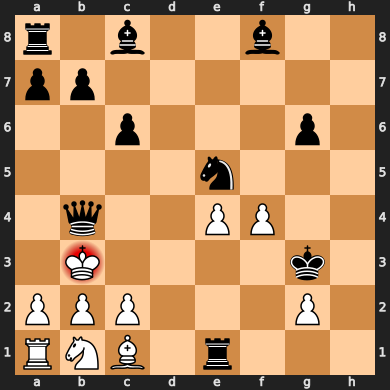

Player <Black> choosed the move: d2b4 with a value of 303487.79
Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)


In [10]:
result = play_game_live(Chess(), depth_white = 1,depth_black =1,  verbose=True)

# Heuristic and Algorithm Test


In [11]:
result = play_chess_games(Chess(), depth_white=2, depth_black=1, games_number=5, verbose=True)

Game 0 started
Game 0 ended in 9.76s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)


Game 1 started
Game 1 ended in 1.77s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)


Game 2 started
Game 2 ended in 21.73s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)


Game 3 started
Game 3 ended in 8.43s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)


Game 4 started
Game 4 ended in 14.83s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)




In [12]:
df = pd.DataFrame(result)
df

,White_Depth,Black_Depth,final_state,winner,termination,game_time(s),total_moves
0,2,1,rnbk1Q2/ppq3pp/2ppB3/8/3PP3/2N5/PPP2PP1/R4RK1 ...,White,Termination.CHECKMATE,9.76,25
1,2,1,rnbqkbnr/ppppp2p/5p2/6pQ/3PP3/8/PPP2PPP/RNB1KB...,White,Termination.CHECKMATE,1.77,5
2,2,1,1nb1kRn1/1p1p3p/3Qr1N1/3B2p1/2PPP3/8/1P4P1/3R2...,White,Termination.CHECKMATE,21.73,57
3,2,1,rnb3kr/1p1p1Q1p/p1p1p3/4Nnp1/2BPP3/7P/PPP3P1/3...,White,Termination.CHECKMATE,8.43,29
4,2,1,rn2k2r/pbqp1N2/1ppQ1P2/6pp/2BP1P2/7P/PPP3P1/3R...,White,Termination.CHECKMATE,14.83,37


In [13]:
result = play_chess_games(Chess(), depth_white=1, depth_black=2, games_number=5, verbose=True)

Game 0 started
Game 0 ended in 24.63s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)


Game 1 started
Game 1 ended in 22.57s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)


Game 2 started
Game 2 ended in 28.58s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)


Game 3 started
Game 3 ended in 21.61s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)


Game 4 started
Game 4 ended in 13.54s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)




In [14]:
df = pd.DataFrame(result)
df

,White_Depth,Black_Depth,final_state,winner,termination,game_time(s),total_moves
0,1,2,3r2k1/1p6/Bb5p/2pp4/1PP1r1bK/P2nPp2/3P3q/RNB1Q...,Black,Termination.CHECKMATE,24.63,56
1,1,2,4r2k/1p4p1/4Bp1p/2p1pP1P/1b4P1/1nN1P1nN/PPb1r3...,Black,Termination.CHECKMATE,22.57,48
2,1,2,4r1k1/1p4p1/2p3b1/3p1pP1/1P1bp1n1/8/PBrPPn2/R4...,Black,Termination.CHECKMATE,28.58,76
3,1,2,3rr1k1/1p6/pb1n2p1/3p1p2/Pp4pP/R2pP1P1/5P1R/2q...,Black,Termination.CHECKMATE,21.61,58
4,1,2,r5kr/Np4p1/5b1p/2p1p3/b1P1nPP1/3p1N2/PP1P1q1P/...,Black,Termination.CHECKMATE,13.54,36


In [15]:
result = play_chess_games(Chess(), depth_white=2, depth_black=2, games_number=3, verbose=True)

Game 0 started
Game 0 ended in 77.96s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)


Game 1 started
Game 1 ended in 148.60s: Outcome(termination=<Termination.SEVENTYFIVE_MOVES: 4>, winner=None)


Game 2 started
Game 2 ended in 107.65s: Outcome(termination=<Termination.SEVENTYFIVE_MOVES: 4>, winner=None)




In [16]:
df = pd.DataFrame(result)
df

,White_Depth,Black_Depth,final_state,winner,termination,game_time(s),total_moves
0,2,2,4R1k1/2N1P1p1/1p4P1/8/4b3/4r1P1/1Pnp4/6K1 b - ...,White,Termination.CHECKMATE,77.96,69
1,2,2,3r2k1/1pN3p1/6Np/2BP1p2/2n5/1P6/2n5/3Rq2K w - ...,None,Termination.SEVENTYFIVE_MOVES,148.60,214
2,2,2,3r2k1/1p4pb/1N1P1pP1/1pp5/2Pp1P2/P2nq3/1Pn3P1/...,None,Termination.SEVENTYFIVE_MOVES,107.65,203


In [17]:
result = play_chess_games(Chess(), depth_white=1, depth_black=3, games_number=1, verbose=True)

Game 0 started
Game 0 ended in 247.07s: Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)




In [18]:
df2 = pd.DataFrame(result)
df2

,White_Depth,Black_Depth,final_state,winner,termination,game_time(s),total_moves
0,1,3,3k1b1r/p3pppp/3p4/1pp5/3P4/1P2q2P/P1PKPNn1/R2Q...,Black,Termination.CHECKMATE,247.07,46


In [19]:
result = play_chess_games(Chess(), depth_white=3, depth_black=3, games_number=10, verbose=True)

Game 0 started
Game 0 ended in 8773.71s: Outcome(termination=<Termination.SEVENTYFIVE_MOVES: 4>, winner=None)


Game 1 started


KeyboardInterrupt: 

In [ ]:
df3 = pd.DataFrame(result)
df3